# Multi-round inference

In the previous tutorials, we have inferred the posterior using **single-round inference**. In **single-round inference**, we draw parameters from the prior, simulate the corresponding data, and then train a neural network to obtain the posterior. However, if one is interested in only one particular observation `x_o` sampling from the prior can be inefficient in the number of simulations because one is effectively learning a posterior estimate for all observations in the prior space. In this tutorial, we show how one can alleviate this issue by performing **multi-round inference** with `sbi`.

**Multi-round inference** also starts by drawing parameters from the prior, simulating them, and training a neural network to estimate the posterior distribution. Afterwards, however, it continues inference in multiple rounds, focusing on a particular observation `x_o`. In each new round of inference, it draws samples from the obtained posterior distribution conditioned at `x_o` (instead of from the prior), simulates these, and trains the network again. This process can be repeated arbitrarily often to get increasingly good approximations to the true posterior distribution at `x_o`.

Running multi-round inference can be more efficient in the number of simulations, but it will lead to the posterior no longer being amortized (i.e. it will be accurate only for a specific observation `x_o`, not for any `x`).


Note, you can find the original version of this notebook at [https://github.com/sbi-dev/sbi/blob/main/tutorials/03_multiround_inference.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/03_multiround_inference.ipynb) in the `sbi` repository.


## Main syntax


In [1]:
import torch

from sbi.analysis import pairplot
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils import BoxUniform



In [2]:
# 2 rounds: first round simulates from the prior, second round simulates parameter set
# that were sampled from the obtained posterior.
num_rounds = 2
num_dim = 3
# The specific observation we want to focus the inference on.
x_o = torch.zeros(num_dim,)
prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
simulator = lambda theta: theta + torch.randn_like(theta) * 0.1

inference = SNPE(prior)

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=500)

    # In `SNLE` and `SNRE`, you should not pass the `proposal` to
    # `.append_simulations()`
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 111 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

## Linear Gaussian example

Below, we give a full example of inferring the posterior distribution over multiple rounds.


First, we define a simple prior and simulator and ensure that they comply with `sbi` by using `prepare_for_sbi`:


In [3]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In [4]:
simulator, prior = prepare_for_sbi(linear_gaussian, prior)

Then, we instantiate the inference object:


In [5]:
inference = SNPE(prior=prior)

And we can run inference. In this example, we will run inference over `2` rounds, potentially leading to a more focused posterior around the observation `x_o`.


In [6]:
num_rounds = 2
x_o = torch.zeros(
    3,
)

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=500)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 83 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Note that, for `num_rounds>1`, the posterior is no longer amortized: it will give good results when sampled around `x=observation`, but possibly bad results for other `x`.


Once we have obtained the posterior, we can `.sample()`, `.log_prob()`, or `.pairplot()` in the same way as for the simple interface.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

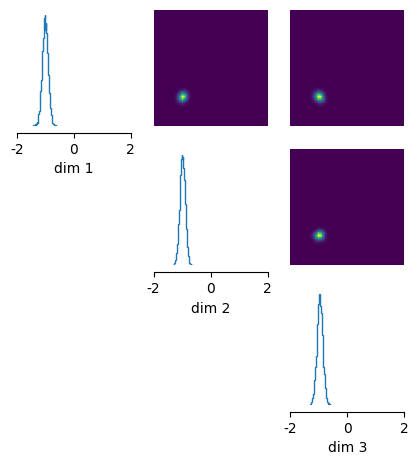

In [7]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
fig, ax = pairplot(
    posterior_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)